In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[0 0 1 2 0 0 0 0 2 2 1 1 2 2 2 1 2 1 1 0 1 0 1 0 0 1 0 1 0 2 1 1]


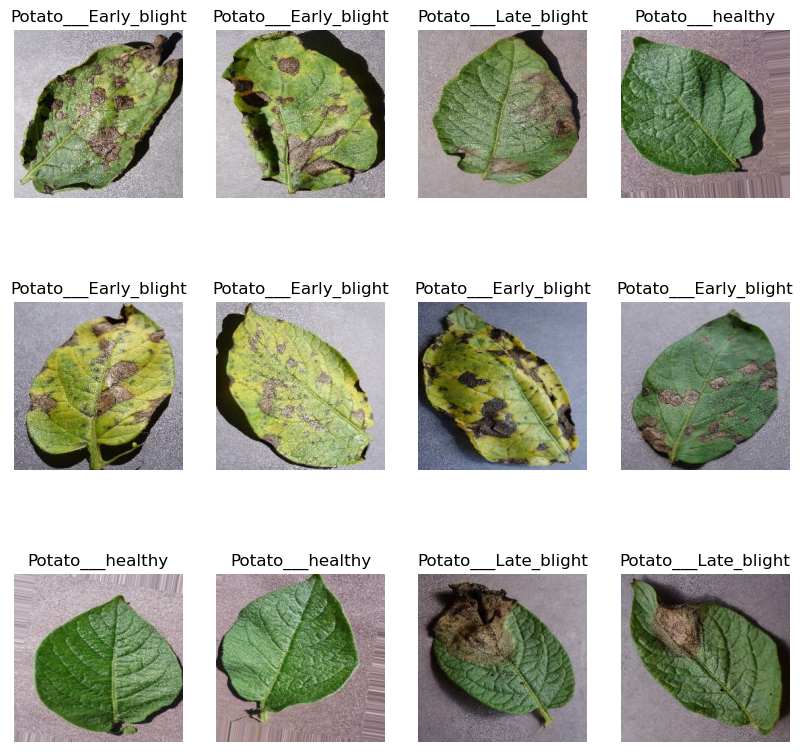

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

32 7 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
32/32 [==============================] - 39s 1s/step - loss: 1.0957 - accuracy: 0.3477 - val_loss: 1.0928 - val_accuracy: 0.3304
Epoch 2/20
32/32 [==============================] - 40s 1s/step - loss: 1.0433 - accuracy: 0.4561 - val_loss: 1.0506 - val_accuracy: 0.4062
Epoch 3/20
32/32 [==============================] - 39s 1s/step - loss: 0.9306 - accuracy: 0.5439 - val_loss: 0.7410 - val_accuracy: 0.6875
Epoch 4/20
32/32 [==============================] - 39s 1s/step - loss: 0.6649 - accuracy: 0.6807 - val_loss: 0.5826 - val_accuracy: 0.7143
Epoch 5/20
32/32 [==============================] - 40s 1s/step - loss: 0.6200 - accuracy: 0.6973 - val_loss: 0.5947 - val_accuracy: 0.6964
Epoch 6/20
32/32 [==============================] - 40s 1s/step - loss: 0.5330 - accuracy: 0.7725 - val_loss: 0.6253 - val_accuracy: 0.7098
Epoch 7/20
32/32 [==============================] - 40s 1s/step - loss: 0.4140 - accuracy: 0.8271 - val_loss: 0.4270 - val_accuracy: 0.8125
Epoch 8/20
32/32 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 219ms/step - loss: 0.2986 - accuracy: 0.8438


[0.29861414432525635, 0.84375]

In [14]:
history.history['loss']

[1.0956847667694092,
 1.0433297157287598,
 0.9306412935256958,
 0.6649219989776611,
 0.6200067400932312,
 0.5330243706703186,
 0.41398075222969055,
 0.45667609572410583,
 0.6911411881446838,
 0.4663422703742981,
 0.3898335099220276,
 0.3145787715911865,
 0.24322600662708282,
 0.19451266527175903,
 0.1776413470506668,
 0.21380993723869324,
 0.15632736682891846,
 0.19565579295158386,
 0.19792194664478302,
 0.20570555329322815]

In [15]:
history.history['accuracy']

[0.34765625,
 0.4560546875,
 0.5439453125,
 0.6806640625,
 0.697265625,
 0.7724609375,
 0.8271484375,
 0.798828125,
 0.708984375,
 0.8095703125,
 0.822265625,
 0.8701171875,
 0.9091796875,
 0.9306640625,
 0.9345703125,
 0.912109375,
 0.9521484375,
 0.935546875,
 0.9267578125,
 0.9306640625]

In [16]:
history.history['val_loss']

[1.0927857160568237,
 1.0506336688995361,
 0.7409712672233582,
 0.5825693011283875,
 0.5947354435920715,
 0.6252670288085938,
 0.4269947409629822,
 0.6800921559333801,
 0.6962348818778992,
 0.8295021057128906,
 0.987530529499054,
 0.5415946841239929,
 0.2443123310804367,
 0.3748447895050049,
 0.24975717067718506,
 0.27451637387275696,
 0.2831536829471588,
 0.7566307187080383,
 0.22769080102443695,
 0.3495454788208008]

In [17]:
history.history['val_accuracy']

[0.3303571343421936,
 0.40625,
 0.6875,
 0.7142857313156128,
 0.6964285969734192,
 0.7098214030265808,
 0.8125,
 0.7142857313156128,
 0.6964285969734192,
 0.5982142686843872,
 0.6026785969734192,
 0.7633928656578064,
 0.8883928656578064,
 0.8303571343421936,
 0.8973214030265808,
 0.8660714030265808,
 0.8973214030265808,
 0.7276785969734192,
 0.8928571343421936,
 0.8258928656578064]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

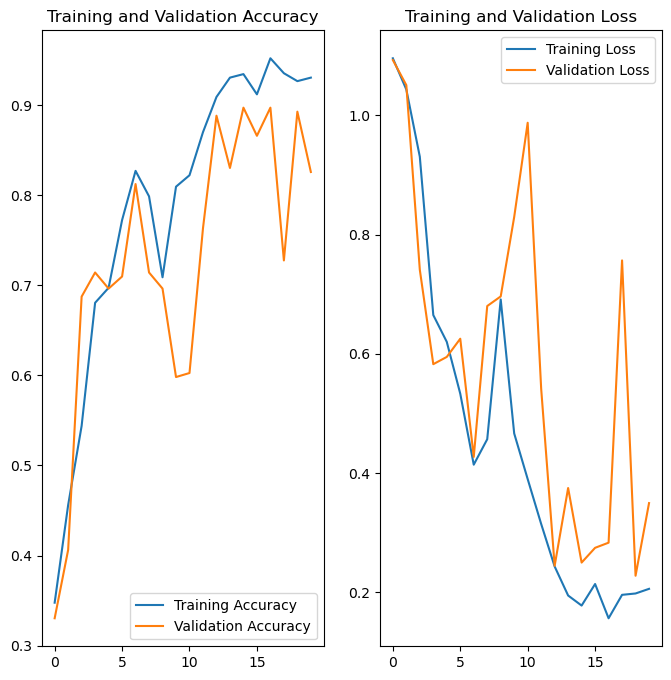

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 301ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


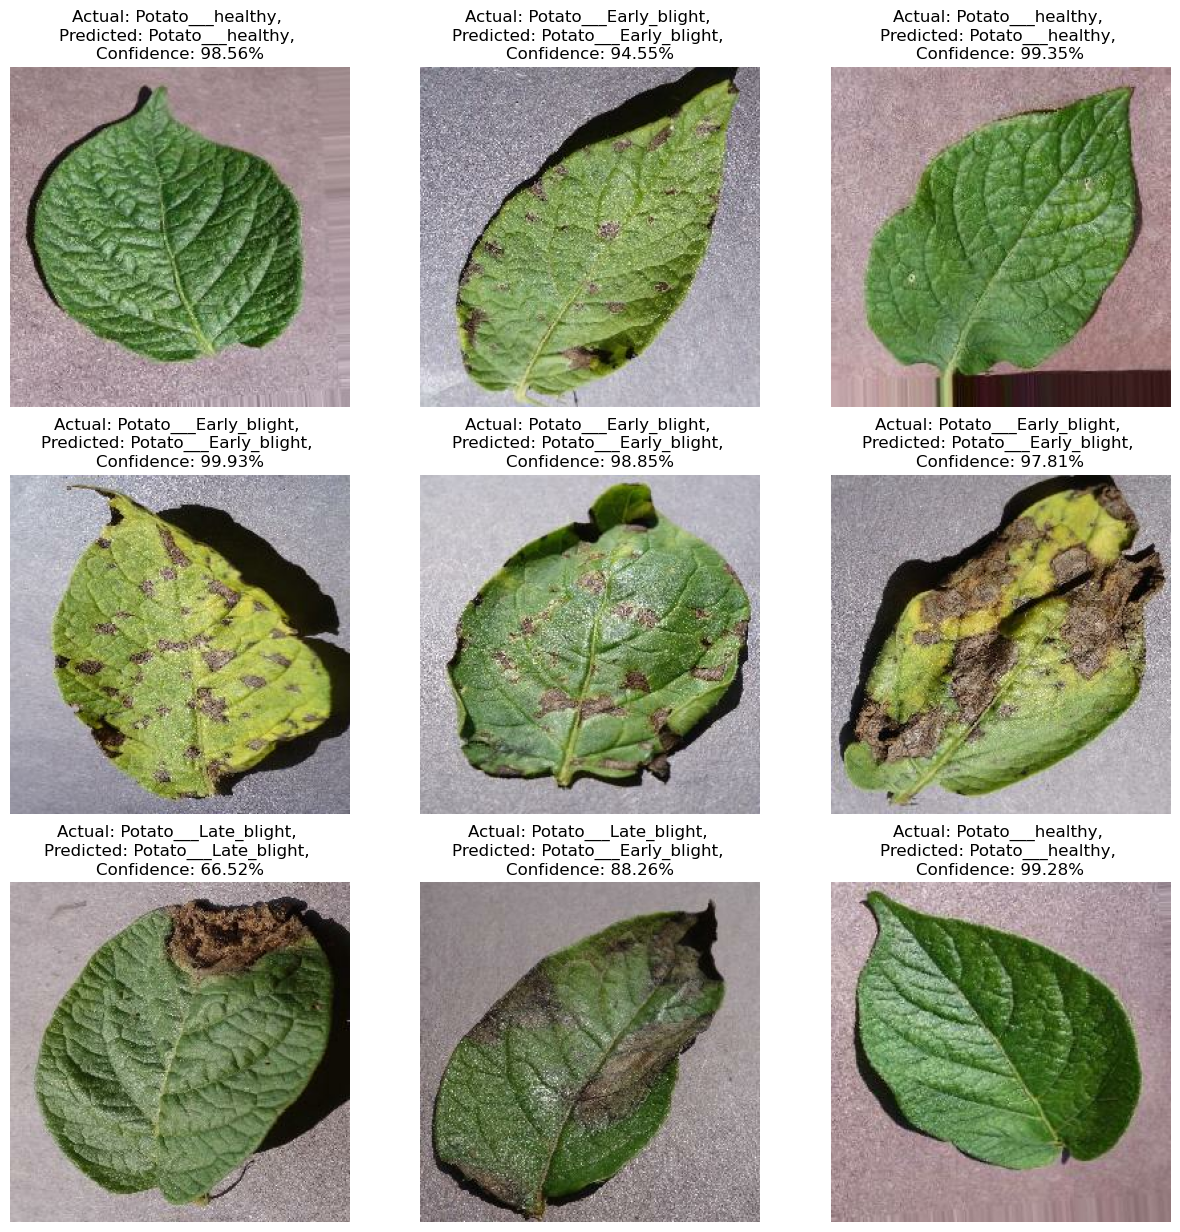

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        86
           1       0.80      0.65      0.72        78
           2       1.00      0.86      0.92        92

    accuracy                           0.84       256
   macro avg       0.85      0.84      0.84       256
weighted avg       0.86      0.84      0.84       256



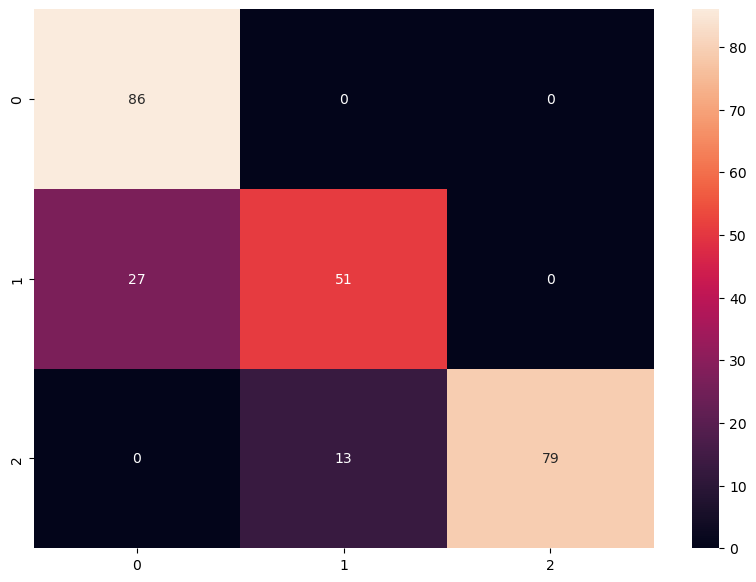

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [25]:
filename = "Model1-2-DatasetSplit70-15-15.joblib"
joblib.dump(model, filename)

['Model1-2-DatasetSplit70-15-15.joblib']